In [1]:
from typing import Optional
import time
import os
import random

from PIL import Image
import PIL
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary as model_summary
import sklearn
from sklearn import model_selection

import monai
from monai.config import print_config

import torch
import torchvision as tv
import torch.nn as nn
from torch.nn import functional as F

print(f'torch.cuda.is_available(): {torch.cuda.is_available()}')
print(f'torch.cuda.get_device_name(0): {torch.cuda.get_device_name(0)}')
print(f'torch.version.cuda: {torch.version.cuda}')
print(f'torch.cuda.device_count(): {torch.cuda.device_count()}')
print()
monai.config.print_config()

/home/kimbg/anaconda3/envs/test1/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.cuda.is_available(): True
torch.cuda.get_device_name(0): NVIDIA GeForce RTX 3060
torch.version.cuda: 11.3
torch.cuda.device_count(): 1

MONAI version: 1.0.0
Numpy version: 1.22.3
Pytorch version: 1.12.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 170093375ce29267e45681fcec09dfa856e1d7e7
MONAI __file__: /home/kimbg/anaconda3/envs/test1/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.13.1
tqdm version: 4.64.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.5.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd ve

In [2]:
### HYPER PARAMETER ###
RANDOM_SEED = 831
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 4
NUM_CLASS = 2
EPOCHS = 10

TEST_ratio = 0.1
VAL_ratio = 0.2

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

root_path = '/data/Segmemtation/Lung Segmentation'
CXR_path = os.path.join(root_path, 'CXR_png')
MASK_path = os.path.join(root_path, 'masks')

In [3]:
CXR_list = sorted(os.listdir(CXR_path))
MASK_list = sorted(os.listdir(MASK_path))
MASK_list_ = list(map(lambda x:x.split('.')[0][:-5]+'.png', MASK_list))
CXR_MASK_union_list = set(MASK_list_) & set(CXR_list)
CXR_path_list = sorted(list(map(lambda x:os.path.join(root_path, 'CXR_png', x), CXR_MASK_union_list)))
MASK_path_list = sorted(list(map(lambda x:os.path.join(root_path, 'masks', x.split('.')[0]+'_mask.png'), CXR_MASK_union_list)))
print(len(CXR_path_list), CXR_path_list[:1])
print(len(MASK_path_list), MASK_path_list[:1])

X, X_test, y, y_test = model_selection.train_test_split(CXR_path_list, MASK_path_list, test_size=TEST_ratio, random_state=RANDOM_SEED)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=VAL_ratio, random_state=RANDOM_SEED)
print(len(X_train), len(X_val), len(X_test))

samplex = tv.io.read_image(X_train[0])
sampley = tv.io.read_image(y_train[0])
print(samplex.shape, samplex.dtype)
print(sampley.shape, sampley.dtype, np.unique(sampley))

566 ['/data/Segmemtation/Lung Segmentation/CXR_png/CHNCXR_0001_0.png']
566 ['/data/Segmemtation/Lung Segmentation/masks/CHNCXR_0001_0_mask.png']
407 102 57
torch.Size([1, 2946, 2994]) torch.uint8
torch.Size([1, 2946, 2994]) torch.uint8 [  0 255]


In [4]:
### DATA LOADER ###
class MyDataLoader(torch.utils.data.Dataset):

    def __init__(self, img_path, img_labels, transforms_x=None, transforms_y=None):
        self.img_path = img_path
        self.img_labels = img_labels
        self.transforms_x = transforms_x
        self.transforms_y = transforms_y

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, index):
        ten_x = tv.io.read_image(self.img_path[index])/255
        if ten_x.shape[0] == 3:
            ten_x = ten_x[:1]
            
        ten_y = tv.io.read_image(self.img_labels[index]).to(torch.int64)
        ten_y = ten_y.squeeze(dim=0)
        tenoh_y = OneHotEncoding(ten_y, num_classes=NUM_CLASS)

        if self.transforms_x:
            ten_x = self.transforms_x(ten_x)        
        if self.transforms_y:
            tenoh_y = self.transforms_y(tenoh_y)        
        
        ten_x = ten_x[0]
        # print(ten_x.shape)
        ten_x = torch.stack([ten_x,ten_x,ten_x], dim=0)
        # print(ten_x.shape)
        return ten_x, tenoh_y
    
    
def OneHotEncoding(labels, num_classes:int):
    shape = labels.shape
    # label_oh = torch.zeros((shape[0], num_classes) + shape[1:]) 
    # print((num_classes, *shape[:]))
    label_oh = torch.zeros(*shape) 
    # print(label_oh.shape)
    for cnt, i in enumerate(sorted(np.unique(labels))):
        i_mask = torch.where(labels == i, cnt, 0)
        label_oh.masked_fill_(i_mask, cnt)
    label_oh = F.one_hot(label_oh.to(torch.int64), num_classes=num_classes)
    label_oh = label_oh.permute(2,0,1).to(torch.float)
    return label_oh


### TRANSFORM & CHECK ###
train_x_transforms = tv.transforms.Compose([
    tv.transforms.Resize(size=IMAGE_SIZE),
    # tv.transforms.ToTensor(), # 자동으로 (0,1)로 변환해줌
     ])    
train_y_transforms = tv.transforms.Compose([
    tv.transforms.Resize(size=IMAGE_SIZE, interpolation=tv.transforms.InterpolationMode.NEAREST),
    # tv.transforms.ToTensor(), # 자동으로 (0,1)로 변환해줌
     ])    

val_x_transforms = tv.transforms.Compose([
    tv.transforms.Resize(size=IMAGE_SIZE),
    # tv.transforms.ToTensor(),
     ])    
val_y_transforms = tv.transforms.Compose([
    tv.transforms.Resize(size=IMAGE_SIZE, interpolation=tv.transforms.InterpolationMode.NEAREST),
    # tv.transforms.ToTensor(),
     ])    

In [5]:
train_ds = MyDataLoader(X_train, y_train, 
                        transforms_x=train_x_transforms, transforms_y=train_y_transforms)
val_ds = MyDataLoader(X_val, y_val, 
                      transforms_x=val_x_transforms, transforms_y=val_y_transforms)
test_ds = MyDataLoader(X_test, y_test, 
                      transforms_x=val_x_transforms, transforms_y=val_y_transforms)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0)

len_train = len(train_loader) 
len_val = len(val_loader) 
len_test = len(test_loader) 
print(len_train, len_val, len_test)

train_sample_x, train_sample_y = next(iter(train_loader))
print(f'train_sample_x.shape: {train_sample_x.shape}')
print(f'train_sample_x.dtpye: {train_sample_x.dtype}')
print(f'train_sample_x.min, max: {torch.min(train_sample_x), torch.max(train_sample_x)}')
print(f'train_sample_y.shape: {train_sample_y.shape}')
print(f'train_sample_y.dtpye: {train_sample_y.dtype}')
print(f'train_sample_y.min, max: {torch.min(train_sample_y), torch.max(train_sample_y)}')
print(f'train_sample_y.unique: {np.unique(train_sample_y)}')

102 102 57
train_sample_x.shape: torch.Size([4, 3, 224, 224])
train_sample_x.dtpye: torch.float32
train_sample_x.min, max: (tensor(0.), tensor(1.))
train_sample_y.shape: torch.Size([4, 2, 224, 224])
train_sample_y.dtpye: torch.float32
train_sample_y.min, max: (tensor(0.), tensor(1.))
train_sample_y.unique: [0. 1.]


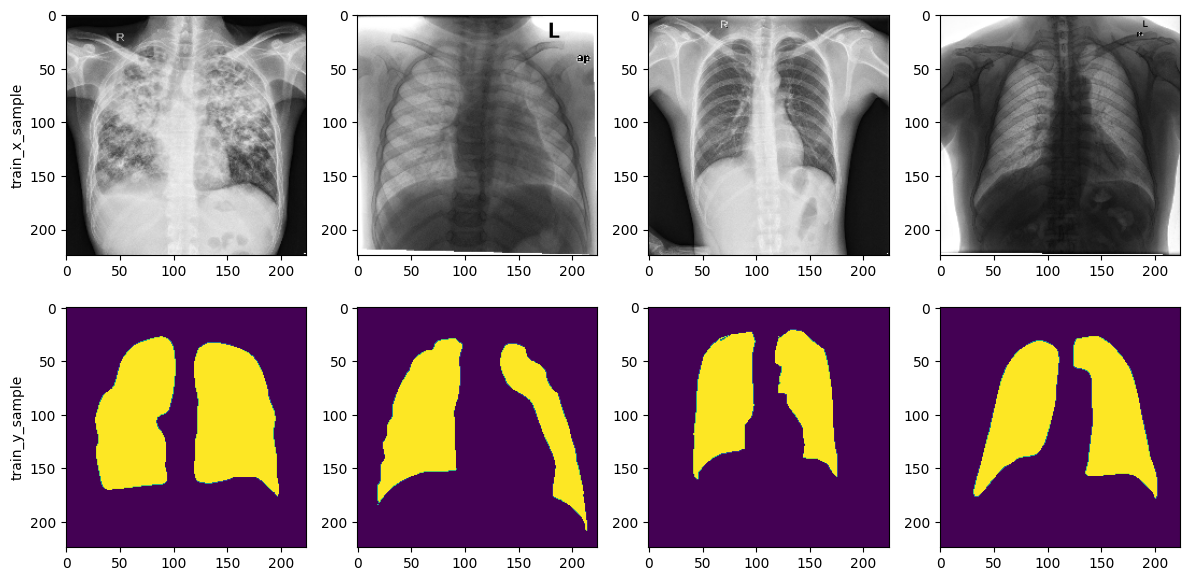

In [6]:
### VISUALIZE ###
ncols, nrows = 4, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
for i in range(ncols):
    img0 = train_sample_x[i].permute(1,2,0)
    img1 = train_sample_y[i].permute(1,2,0)[:,:,-1]
    axes[0,i].imshow(img0)
    # axes[0,i].set_title(f'{class_names[train_sample_y[i]]}')
    axes[0,0].set_ylabel('train_x_sample')
    axes[1,i].imshow(img1)
    # axes[1,i].set_title(f'{class_names[test_sample_y[i]]}')
    axes[1,0].set_ylabel('train_y_sample')
plt.tight_layout()
plt.show()
###################################################

In [7]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, 2, kernel_size=1)
        
    def forward(self, x):
        x = self.block1(x)
        x1 = x
        x = self.block2(x)
        x2 = x
        x = self.block3(x)
        x3 = x
        x = self.block4(x)
        x4 = x
        x = self.block5(x)
        x5 = x
        
        score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        score = score + x4                                # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = score + x3                                # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = score + x2                                # element-wise add, size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = score + x1                                # element-wise add, size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

model = FCN()
model_summary(model, (3,224,224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [8]:
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=2e-4)

CE_LOSS = torch.nn.CrossEntropyLoss()
Metcric_dice = monai.metrics.DiceMetric(include_background=False, reduction="mean")

In [9]:
def train(model, train_loader, optimizer):
    since = time.time()
    model.train() # 훈련 가능하도록 설정
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        step = batch_idx+1
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad() # gradient를 새로 계산하기 위해서 0으로 설정
        output = model(data)
        # loss = F.cross_entropy(output, target) # 평균값으로 계산됨.
        # print(output.dtype)
        # print(target.dtype)
        loss = CE_LOSS(output, target) # 평균값으로 계산됨.
        loss.backward() # 모델의 모든 매개변수의 grad 속성에 gradient를 게산해서 저장
        optimizer.step() # gradient decent 시작. grad 속성에 저장된 gradient에 따라 각 매개변수를 조정(adjust)함.
        epoch_loss += loss.item()
        dice_output = torch.where(output>=0.5, 1, 0)
        Metcric_dice(y_pred=dice_output, y=target) # compute metric for current iteration
        
    epoch_loss /= step
    dice_score = Metcric_dice.aggregate().item() # aggregate the final mean dice result
    Metcric_dice.reset() # reset the status for next validation round

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    return epoch_loss, dice_score
    
        
def evaluate(model, test_loader):
    model.eval() # 평가 모드로 설정
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            step = batch_idx+1
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            
            loss += CE_LOSS(output, target).item() # 평균값으로 계산됨.
            dice_output = torch.where(output>=0.5, 1, 0)
            Metcric_dice(y_pred=dice_output, y=target) # compute metric for current iteration
            
    loss /= len(val_ds) # 전체 데이터셋의 길이
    dice_score = Metcric_dice.aggregate().item() # aggregate the final mean dice result
    Metcric_dice.reset() # reset the status for next validation round
    
    return loss, dice_score

In [10]:
losses = {'train':[], 'val':[]}
dice_scores = {'train':[], 'val':[]}
best_metric, best_epoch = 999, -1

for epoch in range(1, EPOCHS+1):
    train_loss, train_dice_score = train(model, train_loader, optimizer)
    val_loss, val_dice_score = evaluate(model, val_loader)
    
    losses['train'].append(train_loss)
    losses['val'].append(val_loss)
    dice_scores['train'].append(train_dice_score)
    dice_scores['val'].append(val_dice_score)

    print(f'[{epoch}] Train Loss: {train_loss:.6f}, Dice score: {train_dice_score:.6f}')
    print(f'[{epoch}] Test Loss: {val_loss:.6f}, Dice score: {val_dice_score:.6f}')
    
    if losses['val'][-1] < best_metric:
        best_metric = losses['val'][-1]
        best_epoch = epoch
        torch.save(model.state_dict(), f'./Segmentation(base)-epoch_{best_epoch}.pth')
        # torch.save(model.state_dict(), f'./Segmentation(base)_test.pth')
        print('saved model')


Training complete in 1m 27s
[1] Train Loss: 0.306187, Dice score: 0.665322
[1] Test Loss: 0.847357, Dice score: 0.000000
saved model
Training complete in 1m 26s
[2] Train Loss: 0.168609, Dice score: 0.843114
[2] Test Loss: 0.197056, Dice score: 0.680112
saved model
Training complete in 1m 26s
[3] Train Loss: 0.132799, Dice score: 0.877354
[3] Test Loss: 0.222785, Dice score: 0.893338
Training complete in 1m 26s
[4] Train Loss: 0.115439, Dice score: 0.890321
[4] Test Loss: 0.132806, Dice score: 0.813246
saved model
Training complete in 1m 27s
[5] Train Loss: 0.109775, Dice score: 0.893997
[5] Test Loss: 0.105742, Dice score: 0.922599
saved model
Training complete in 1m 26s
[6] Train Loss: 0.098552, Dice score: 0.903029
[6] Test Loss: 0.199390, Dice score: 0.909055
Training complete in 1m 26s
[7] Train Loss: 0.097074, Dice score: 0.902870
[7] Test Loss: 0.107848, Dice score: 0.858085
Training complete in 1m 26s
[8] Train Loss: 0.091529, Dice score: 0.909517
[8] Test Loss: 0.099477, Dice 

In [11]:
print(f"train completed, best_metric: {best_metric:.4f} \n" 
      f"at epoch: {best_epoch}")     

train completed, best_metric: 0.0767 
at epoch: 10


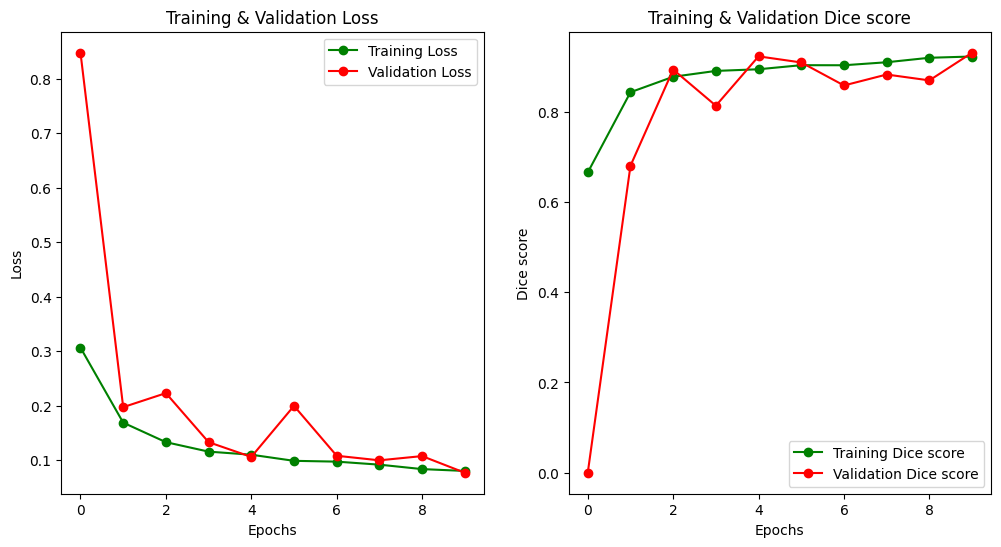

In [12]:
epochs = [i for i in range(len(losses['train']))]
train_loss = losses['train']
val_loss = losses['val']
train_dice = dice_scores['train']
val_dice = dice_scores['val']

fig , ax = plt.subplots(1,2)
fig.set_size_inches(12,6)

ax[0].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[0].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(epochs , train_dice , 'go-' , label = 'Training Dice score')
ax[1].plot(epochs , val_dice , 'ro-' , label = 'Validation Dice score')
ax[1].set_title('Training & Validation Dice score')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Dice score")
plt.show()

In [13]:
test_ds = MyDataLoader(X_test, y_test, 
                      transforms_x=val_x_transforms, transforms_y=val_y_transforms)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0)
len_test = len(test_loader)

pred_dict = {'input':[], 'target':[], 'output':[]}

model.load_state_dict(torch.load(f'./Segmentation(base)-epoch_{best_epoch}.pth'))
model.to('cpu')
model.eval()
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data, target = data.to('cpu'), target.to('cpu')
        output = model(data).detach().cpu()
        
        data_ = data[0].permute(1,2,0)
        target_ = target[0].permute(1,2,0)[:,:,-1]
        output_ = output[0].permute(1,2,0)[:,:,-1]
        
        pred_dict['input'].append(data_)
        pred_dict['target'].append(target_)
        pred_dict['output'].append(output_)

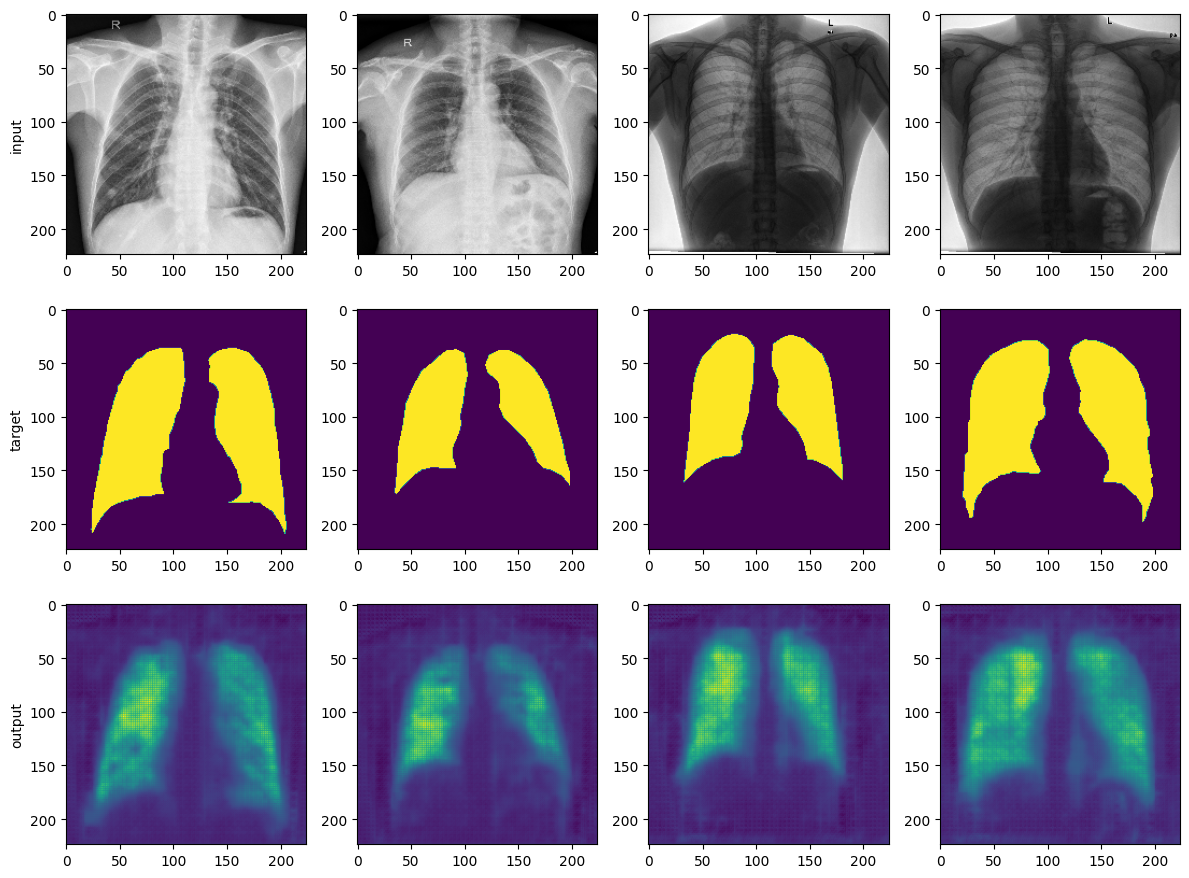

In [14]:
ncols, nrows = 4, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
for i in range(ncols):
    axes[0,i].imshow(pred_dict['input'][i])
    # axes[0,i].set_title(f'{class_names[train_sample_y[i]]}')
    axes[0,0].set_ylabel('input')
    axes[1,i].imshow(pred_dict['target'][i])
    # axes[1,i].set_title(f'{class_names[test_sample_y[i]]}')
    axes[1,0].set_ylabel('target')

    axes[2,i].imshow(pred_dict['output'][i])
    # axes[1,i].set_title(f'{class_names[test_sample_y[i]]}')
    axes[2,0].set_ylabel('output')

plt.tight_layout()
plt.show()